#  Halo Mass Function 

<!-- --- -->


**Nikolaos Triantafyllou**\
**Scuola Normale Superiore**\
**Spring 2023-2024**<Br>

    


Steven Murray's HMF:     https://hmf.readthedocs.io/en/latest/index.html

Liddle et al. 1996: https://arxiv.org/abs/astro-ph/9512102

Eisenstein & Hu 1999: https://arxiv.org/abs/astro-ph/9710252

Note: It takes less than 30 seconds to run the notebook

--- --- 

## Steps:

1) Calculate the power per lnk PS $\Delta_k^2$:

$$\sigma_k^2 \equiv A\; k^n \; T^2(k)\; D^2(z,k)$$

$$ \Delta_k^2 = \frac{V^{-1}}{2\pi^2} k^3 \sigma_k^2$$

2) Calculate the Mass Power Spectrum (i.e. variance in the mass field) using some window function

$$ \sigma^2_M(R) \equiv \left<\delta_M^2 \right> = \frac{1}{V_W^2} \int_0^\infty \Delta_k^2 W_k^2 \frac{dk}{k}$$

3) Calculate the Press Schechter HMF:

$$\frac{df_{coll}(>M,z)}{dM} = \sqrt{\frac{2}{\pi}}   \frac{\delta_c(z)}{\sigma_M^2(M)}  \left| \frac{d\sigma_M(M)}{dM}  \right|  exp \left[ - \frac{\delta_c^2(z)}{2\sigma_M^2(M)} \right]$$


$$\frac{dn(>M)}{dM} = \frac{\bar{\rho_0}}{M} \frac{df_{coll}(>M,z)}{dM} $$



--- --- 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

from my_integrals import my_simpson
from my_integrals import derivative2
from scipy.integrate import quad
from scipy.integrate import simpson

from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

import hmf
import astropy

FRACT_FLOAT_ERR = 1e-6

def isequal(a,b):
    if (abs(a-b) <= FRACT_FLOAT_ERR): return True
    else: return False
    
# CHANGEABLE PARAMETERS----------------------------------------------------------------
    
# Cosmological Parameters
OMm         = 0.3111       # Total mass density (CDM baryons and massive neutrinos)
OMl         = 0.6889
OMb         = 0.0224      # Baryon density 
OMtot       = (OMm + OMl)
hlittle     = 0.674

OMnu        = 0.00064         # Massive neutrino density
THETA27     = 2.728/2.7
T_CMB       = 2.7* THETA27 # CMB temperature [Kelvin] 
Nnu         = 2.99            # Number of neutrino species degenerate in mass
PS_index_n  = 0.965

SIGMA8      = 0.81
# POWER_INDEX = 0.96
wl          = -1.0
H_0=100*hlittle # km s^-1 Mpc^-1
USE_TRANSFER = 'T_EH98'
REDSHIFT = 0  
USE_WINDOW = 'spherical_top_hat'

# CHANGEABLE PARAMETERS END\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\

# mean density RHO_0
G = 4.3009172706 * 1e-3 # pc Msun-1 (km/s)^2
m_in_Mpc = 3.24078e-23 # Mpc
G_cosmo_units = G * 1e-6 * pow( 1000 * m_in_Mpc ,2)  #  Mpc^3 Msun-1 s-2
H_0=100*hlittle # km s^-1 Mpc^-1
H_0_cosmo_units = H_0 * 1000 * m_in_Mpc
rho_crit = 3 * pow(H_0_cosmo_units, 2) /  (8 * np.pi * G_cosmo_units)

RHO_0 = OMm * rho_crit # Msun / Mpc^3
    
# Initialize Steven's code (NOTE: for some combinations of the previous parameters,
# some of the following parameters should also change 
lnkmin, lnkmax, dlnk = np.log(1e-8), np.log(1e5), 0.01
c2 = 931.46 * 10e6 # eV
mf = hmf.MassFunction(z               = REDSHIFT,
                  transfer_model  = 'EH_NoBAO', 
                  lnk_min         = lnkmin, 
                  lnk_max         = lnkmax, 
                  dlnk            = dlnk, 
#                   transfer_params = {"use_sugiyama_baryons": True}, 
#                   cosmo_model     = cosmo_model,
                  cosmo_params    = {'Om0': OMm-OMnu, 
                                     'Ob0' : OMb, 
#                                      'Ol0' : 1. - OMm,
                                     'H0' : H_0,
#                                      'Ode0': OMl,
                                     'Tcmb0': THETA27*2.7,
                                     'Neff': Nnu,
                                     'm_nu': 91.5 * OMnu* pow(hlittle, 2)* pow(Nnu, -1) * pow(c2, -1)   , # eV
                                     'Ob0': OMb  
                                      },
                  n               = PS_index_n,
                  sigma_8         = SIGMA8,
                  takahashi       = False,
                  growth_model    = hmf.cosmology.growth_factor.Carroll1992,
                  growth_params   = {},
                  hmf_model       = hmf.mass_function.fitting_functions.PS,
                  hmf_params      = {},
                  filter_model    = hmf.density_field.filters.TopHat,
                  filter_params   = {},
                  disable_mass_conversion = False,
#                   mdef_model      = hmf.halos.mass_definitions.SOCritical,
                  mdef_params     = {},
                  Mmin            = 10,
                  Mmax            = 15,
                  dlog10m         = 0.01,
#                   delta_c         = delta_c(REDSHIFT)
                  
                
                  )

## Step 1: Caclulate PS 


$$\sigma_k^2 = A\; k^n \; T^2(k)\; D^2(z,k)$$

$$ \Delta_k^2 = \frac{V^{-1}}{2\pi^2} k^3 \sigma_k^2$$

### 1.1 Growth factor

See Liddle et al. 1996 eq (6):
$$g(\Omega)= \frac{5}{2} \Omega \left[ \frac{1}{70} + \frac{209 \Omega}{140} - \frac{\Omega^2}{140} + \Omega^{4/7} \right] ^{-1}$$
This formula can be applied for any value of $\Omega$ (mass density). For a matter dominated flat Universe, the redshift dependence of $\Omega$ is given by:
$$\Omega(z) = \Omega_0 \frac{(1+z)^3}{1-\Omega_0 + (1+z)^3 \Omega_0}$$

the growth factor is:
$$D(z) = \frac{g(\Omega(z))}{g(\Omega_0)} \frac{1}{1+z}$$

In [51]:
# eq. 6 from liddle et al. 1994
def g_z(OMm_z):
    return (  (5.0/2.0)*OMm_z/( (1.0/70.0) + 
             (209.0/140.0)*OMm_z - OMm_z*OMm_z/140.0 + 
             pow(OMm_z, 4.0/7.0) )  
        )

def growth_factor(Z, OMm=OMm, OMl=OMl):
    
    # Einstein-de-Sitter
    if isequal(OMm,1) and isequal(OMtot, OMm):
        return 1.0/(1.0+Z)
    
    # eq 7 of liddle et al.; 1994
    #Lambda CDM
    if isequal(OMtot, OMm+OMl) and isequal(OMtot,1):
        OMm_z = OMm*pow(1+Z, 3) / (1 - OMm + OMm*pow(1+Z, 3))
        return g_z(OMm_z)/( g_z(OMm)*(1.0+Z) );
        
    print("ERROR: no growth function for this cosmology! returning -1\n")
    return -1


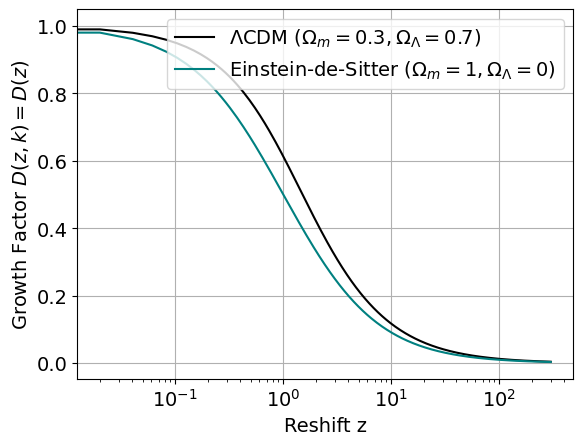

In [52]:
# Check the behavior of the growth factor for an Einstei de Sitter Universe and a LCDM 
Z_FACTOR = 1.02
Z=0
Z_arr = []
growth_factor_arr = []
while (Z<300):
    Z_arr.append(Z)
    growth_factor_arr.append(growth_factor(Z,0.3,0.7))
    
    Z=(1+Z)*Z_FACTOR-1
    
    
Z_FACTOR = 1.02
Z=0
Z_arr = []
growth_factor_arr2 = [] 
while (Z<300):
    Z_arr.append(Z)
    growth_factor_arr2.append(growth_factor(Z,1.0,0.0))
    
    Z=(1+Z)*Z_FACTOR-1
    
plt.plot(Z_arr, growth_factor_arr, color='black', marker='o', markersize=0, label= r"$\Lambda \rm CDM$ ($\Omega_m=0.3$$, \Omega_\Lambda=0.7$)")
plt.plot(Z_arr, growth_factor_arr2, color='teal', marker='o', markersize=0, label=r"Einstein-de-Sitter ($\Omega_m=1$$, \Omega_\Lambda=0$)")
plt.xlabel('Reshift z')
plt.xscale('log')
plt.ylabel(r'Growth Factor $D(z,k)=D(z)$')
# plt.title(label=fr'$\Omega_m = {OMm}$, $\Omega_\Lambda = {OMl}$');
plt.legend()
plt.grid()

### 1.2 Transfer Function

The transfer function is the one for Eisenstein & Hu 1999 eq. 24. 
The dependencies are:

- Wavenumber (k)
- Redshift (z)


#### Definitions for all eqs (1)-(24) from EH99 to get T_master:

In [53]:
# eq. (1): The redshift of matter-radiation equality
Zeq = 2.50 * pow(10,4) * OMm * pow(hlittle, 2) * pow(THETA27,-4)

# eq. (2): The redshift at which baryons are realised from the Compton drag of the photons:
b1 = 0.313 * pow(OMm*pow(hlittle,2), -0.419 ) * ( 1 + 0.607 * pow(OMm*pow(hlittle,2), 0.674 ) )
b2 = 0.238 * pow(OMm*pow(hlittle,2), 0.223 )
# use b1, b2 in the eq:
Zd = 1291. * (  pow(OMm* pow(hlittle,2), 0.251) /  (  1. + 0.659 * pow(OMm* pow(hlittle,2), 0.828) )    )  * (  1. + b1 * pow(OMb* pow(hlittle,2), b2)  )

# eq. (3): It is more convenient to label this epoch by the relative expansion since matter-radiation equality, so we define:
y_d = (1. + Zeq) / (1. + Zd) 

# eq. (4): Sound Horizon (The comoving distance that a sound wave can propagate prior to Zd)
sound_horizon = 44.5 * np.log(9.83 / ( OMm* pow(hlittle,2) )  ) /   np.sqrt(1 + 10* pow(OMb* pow(hlittle,2), 3/4.0)  )   # [Mpc]
                              
# eq. (5): Parametrization on the comoving wave number k 
def q(k):                              
    return k * pow(THETA27, 2) * pow(OMm*pow(hlittle,2), -1)

'''
Equations (6) and (7) are the transfer functions for cb and cbv-for now I skip them
Equations (8) (9) (10) are for the growth factor $D_1$ from EH99.
'''

# eq. (9)
def g2(Z, OMm=OMm, OMl=OMl):
    return OMm* pow(1+Z, 3) + (1-OMm-OMl)* pow(1+Z,2) + OMl
    
# eq. (10)
def EH_Omega(Z):
    return OMm * pow(1+Z, 3) * 1/g2(Z) 

def EH_OmegaL(Z):
    return OMl/g2(Z)

def D1(Z):
    return (1. + Zeq) / (1. + Z) * (5.* EH_Omega(Z)/2.0) * pow(  pow(EH_Omega(Z), 4.0/7.0) - EH_OmegaL(Z) + (1. + EH_Omega(Z)/2.0)*(1. + EH_OmegaL(Z)/70.0), -1.)

# Let's code the scale dependent MDM growth factors $D_{cb}, D_{cbv}$

# eq. (11) factor for altering the logarithmic growtth rate (p_cb and p_c)
f_c  = (OMm - OMnu - OMb)/OMm
f_b  = OMb/OMm
f_nu = OMnu/OMm

TINY=1e-11
if (f_nu < TINY): f_nu = 1e-10
if (f_b < TINY): f_baryon = 1e-10


f_cb = f_c + f_b
f_vb = f_nu + f_b 

p_cb = 1/4.0 * (5- np.sqrt(1 + 24 * f_cb)  )
p_c  = 1/4.0 * (5- np.sqrt(1 + 24 * f_c)  )


# eq. (12) (13) (14)

# first eq. (14): Free streaming epoch as a function of scale:
def y_fs(k): # y_fs(q(k))
    return 17.2* f_nu * ( 1 + 0.488 * pow(f_nu, - 7/6.0) ) * pow(Nnu * q(k)/ f_nu, 2)

#CORRECT EH99=====================================================================================================
# eq. (12) growth rate in the presence of streaming 
def D_cb(k, Z):
    return pow( 1+ pow(D1(Z)/(1+y_fs(k)) , 0.7) , p_cb/0.7) * pow( D1(Z), 1 - p_cb)

def D_cbv(k, Z):
    return pow(   pow(f_cb, 0.7/p_cb)   +  pow(D1(Z)/( 1 + y_fs(k) ),0.7  ) ,  p_cb/0.7  ) *  pow( D1(Z), 1 - p_cb)



# eq (15) The amount of small scale supression:

a_nu_1 = f_c/f_cb  *  ( 5 - 2*(p_c + p_cb) ) / ( 5 - 4*p_cb)

a_nu_2 = ( 1 - 0.553* f_vb + 0.126* pow(f_vb, 3) ) /  ( 1 - 0.193* pow(f_nu* Nnu, 1/2.0) + 0.169 * f_nu * pow(Nnu, 0.2) )     * pow(1 + y_d, p_cb - p_c)

a_nu_3 = 1+ (p_c - p_cb)/2.0 *   ( 1 + pow( (3 - 4*p_c)*(7 - 4*p_cb), -1 )  ) * pow(1 + y_d, -1)

a_nu = a_nu_1* a_nu_2* a_nu_3



# eq. (16) Zero baryon shape parameter Γ
def Gamma_eff(k):
    return OMm* pow(hlittle, 2) * ( pow(a_nu, 1/2.0) +  (1 - pow(a_nu, 1/2.0)) / (1 + pow(0.43* k * sound_horizon, 4) )   )

# eq. (17)
def q_eff(k): 
    return k * pow(THETA27, 2) / Gamma_eff(k) # * [Mpc]


# eq. (18) (19) (20) (21)

# eq. (21)
beta_c = pow(1 - 0.949*f_vb, -1)

# eq. (19)
def L(k):
    return np.log(np.e + 1.84* beta_c * pow(a_nu, 1/2.0) * q_eff(k))

# eq. (20)
def C(k):
    return 14.4 + 325 / ( 1 + 60.5 * pow( q_eff(k), 1.11) )

# eq. (18)
def T_sup(k):
    return L(k) / (L(k) + C(k)* pow(q_eff(k), 2) )

# eq (22) (23) (24)

# eq. (23)
def q_nu(k):
    return 3.92* q(k) * pow(Nnu/ f_nu, 1/2.0)

# eq. (22)
def B(k):
    return 1 + (1.24* pow(f_nu, 0.64) * pow(Nnu, 0.3 + 0.6* f_nu) ) / (pow(q_nu(k), -1.6) + pow(q_nu(k), 0.8) )

# eq.(24)

def T_master(k, Z='dummy'):
    return T_sup(k) * B(k)

Set up the final transfer functions $T_{cb}$, $T_{cbv}$ (eq. (6) (7)) and $T_{CDM}$ (from eq. (18) but with $a_\nu=\beta_c=1$ and $q_{eff}=q$)

In [54]:
def T_cb(k, Z=0):
    return T_master(k)* D_cb(k,Z)/ D1(Z)

def T_cbv(k, Z=0):
    return T_master(k)* D_cbv(k,Z)/ D1(Z)

In [55]:
# There is obviously a better way to do this
# but this is the quickest one and the easiest to check mistakes 

# eq. (19)
def Lcdm(k):
    return np.log(np.e + 1.84 *  q(k))

# eq. (20)
def Ccdm(k):
    return 14.4 + 325 / ( 1 + 60.5 * pow( q(k), 1.11) )

def T_CDM(k, Z='dummy'):
     return Lcdm(k) / (Lcdm(k) + Ccdm(k)* pow(q(k), 2) )
    
T_sup_CDM = T_CDM
    
def T_master_CDM(k, Z='dummy'):
    return T_sup_CDM(k)* B(k)

def T_cb_CDM(k, Z=0):
    return T_master_CDM(k)* D_cb(k,Z)/ D1(Z)

def T_cbv_CDM(k, Z=0):
    return T_master_CDM(k)* D_cbv(k,Z)/ D1(Z)

#### Also transfer from EH 1998

In [56]:
a_gamma98 = 1 - 0.328 * np.log(431* OMm* hlittle**2) * OMb/OMm  +  0.38 * np.log(22.3 * OMm * hlittle**2) * (OMb/OMm)**2

def gamma98(k):
    return OMm* hlittle * ( a_gamma98 + (1 - a_gamma98)/ (1 + (0.43 * k * sound_horizon)**4)   )

def q98(k):
    return k* THETA27**2/ (hlittle * gamma98(k))

def L_0(k):
    return np.log(2* np.e + 1.8 * q98(k))

def C_0(k):
    return 14.2 + 731/ (1 + 62.5 * q98(k))
    
def T_EH98(k, Z='dummy'):
    return L_0(k) / (L_0(k) + C_0(k) * q98(k)**2)
    

#### Also code the $T_{CDM}$ of liddle eq. (4)

In [57]:
Gamma_liddle = OMm* hlittle* np.exp(-OMb-OMb/OMm)

def q_liddle(k):
    return k/(hlittle* Gamma_liddle) # with or without hlittle multiplying gamma

def T_CDM_liddle(k, Z='dummy'):
    qk = q_liddle(k)
    return np.log(1 + 2.34* qk) /  (2.34*qk)  *    ( 1 + 3.89* qk + (16.1* qk)**2  + (5.46* qk)**3 + (6.71* qk)**4 )**(-1/4.)

#### Also code transfer from 21cmfast 

In [58]:
theta_cmb = THETA27
omhh = OMm*hlittle**2 
cosmo_params_ps = {
    'OMb': OMb,  # Baryon density parameter
    'hlittle': hlittle  # Reduced Hubble constant
}
f_baryon=f_b
N_nu=Nnu

alpha_nu = a_nu

def TFmdm(k, Z='dummy'):
    qzx = k * theta_cmb**2 / omhh
    gamma_effzx = np.sqrt(a_nu) + (1.0 - np.sqrt(a_nu)) / (1.0 + pow(0.43 * k * sound_horizon, 4))
    q_effzx = qzx / gamma_effzx
    TF_m = np.log(np.e + 1.84 * beta_c * np.sqrt(a_nu) * q_effzx)
    TF_m /= TF_m + pow(q_effzx, 2) * (14.4 + 325.0 / (1.0 + 60.5 * pow(q_effzx, 1.11)))
    q_nu = 3.92 * qzx / np.sqrt(f_nu / N_nu)
    TF_m *= 1.0 + (1.2 * np.power(f_nu, 0.64) * np.power(N_nu, 0.3 + 0.6 * f_nu)) / (np.power(q_nu, -1.6) + np.power(q_nu, 0.8))
    return TF_m
 
    
    


In [59]:
T_master(0.1)

0.09695801071356493

In [60]:
TFmdm(0.1)

0.09695558125392048

### Test the Transfer functions

In [61]:
# Define the k range corresponding to the EH99 plots (NOTE: logspace would have been better)
kh_arr = np.linspace(0.003*hlittle,5*hlittle,1000)

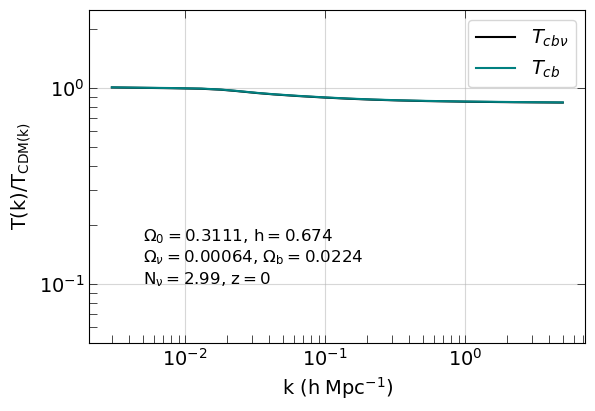

In [62]:
# Plotting Eisenstein & Hu Figure 1 and 2 (redshift =0 and 9 respectively)
# NOTE: only if OMnu!= 0 since Tcb and Tcbv would divide by 0 at some point
if OMnu!=0:
    T_sup_CDM=T_CDM
    redshift=0
    plt.plot(kh_arr/hlittle, T_cbv(kh_arr, Z=redshift)/T_sup_CDM(kh_arr), label=r'$T_{cb\nu}$', color='black', alpha=1)
    plt.plot(kh_arr/hlittle, T_cb(kh_arr, Z=redshift)/T_sup_CDM(kh_arr), label = r'$T_{cb}$', color= 'teal', alpha=1)
    plt.text(0.005, 0.1,  
             f'$\\Omega_0={OMm}$, $\\rm h={hlittle}$ \n$\\Omega_\\nu={OMnu}$, $\\rm \\Omega_b={OMb}$ \n$\\rm N_\\nu={Nnu}$, $\\rm z={redshift}$', 
             fontsize=12)
    
    # Make the plot pretty
    plt.xlabel(r'k ($\rm h \; Mpc^{-1}$)')
    plt.ylabel(r'$\rm T(k)/T_{CDM(k)}$')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([0.05,2.5])
    plt.legend()
    plt.gca().set_aspect(1.4)
    plt.tick_params(bottom=True, top=True, left=True, right=True)
    plt.tick_params(which='both', direction='in', length=6, width=0.5, colors='black', grid_alpha=0.5)
    plt.grid()

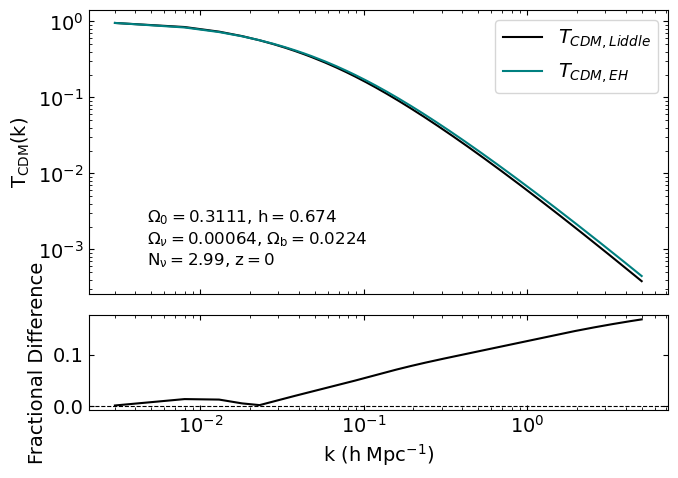

In [63]:
redshift=REDSHIFT
# Plotting the T_CDM from Eisenstein and Hu and the one from liddle 
T_sup_CDM=T_CDM
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(kh_arr/hlittle, T_CDM_liddle(kh_arr), label=r'$T_{CDM,Liddle}$', color='black', alpha=1)
ax1.plot(kh_arr/hlittle, T_sup_CDM(kh_arr), label=r'$T_{CDM, EH}$', color='teal', alpha=1)
ax1.set_ylabel(r'$\rm T_{CDM}(k)$')
ax1.legend()
ax1.set_yscale('log')
ax1.tick_params(which='both', direction='in', top=True, right=True)

#  Difference between the two transfer functions
difference = abs(T_CDM_liddle(kh_arr) - T_sup_CDM(kh_arr))/ T_CDM_liddle(kh_arr)

ax2.plot(kh_arr/hlittle, difference, label='Difference', color='black')
ax2.set_xlabel(r'k ($\rm h \; Mpc^{-1}$)')
ax2.set_ylabel('Fractional Difference')
ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal line at y=0
ax2.tick_params(which='both', direction='in', top=True, right=True)
ax2.set_xscale('log')


# Make the plot pretty
plt.tight_layout()
ax1.text(0.1, 0.1,  
         f'$\\Omega_0={OMm}$, $\\rm h={hlittle}$ \n$\\Omega_\\nu={OMnu}$, $\\rm \\Omega_b={OMb}$ \n$\\rm N_\\nu={Nnu}$, $\\rm z={redshift}$', 
         fontsize=12, transform=ax1.transAxes)
plt.show()

In [64]:
# Substitute the USE_TRANSFER parameter with the actual transfer function
if   USE_TRANSFER == 'T_CDM': USE_TRANSFER = T_CDM
elif USE_TRANSFER == 'T_master_CDM': USE_TRANSFER = T_master_CDM
elif USE_TRANSFER == 'T_CDM_liddle': USE_TRANSFER = T_CDM_liddle
elif USE_TRANSFER == 'T_cb' : USE_TRANSFER = T_cb
elif USE_TRANSFER == 'T_cbv': USE_TRANSFER = T_cbv
elif USE_TRANSFER == 'T_EH98': USE_TRANSFER = T_EH98
elif USE_TRANSFER == 'T_cm21': USE_TRANSFER = TFmdm

### 1.3 Power Spectrum

Power spectrum for EH99 (eq.25):

$$(V^{-1}?)\;\;\frac{k^3}{2\pi^2} P(k,z)=\delta_H^2 \left( \frac{ck}{H_0}\right) ^{3+n}     \frac{T^2(k,z) D^2_1(z)}{D^2_1(0)}$$


$$\sigma_k^2 = A\; k^n \; T^2(k)\; D^2(z,k)$$

$$ \Delta_k^2 = \frac{V^{-1}}{2\pi^2} k^3 \sigma_k^2$$

In [65]:
def growth_factor_EH(Z):
    return D1(Z) / D1(0)

def sigma_k2(k, Z, transfer = USE_TRANSFER):
    return pow(k, PS_index_n)   *   pow(transfer(k,Z),2) *(
#     pow(D1(Z), 2) / pow(D1(0),2) 
        pow(growth_factor(Z),2)
    )

def power_per_k(k, Z, transfer = USE_TRANSFER, box_volume='dummy'):
    return pow(k,3)/(2*pow(np.pi,2)) * sigma_k2(k,Z,transfer)

# The position of the peak in the power spectrum is generally determined by the scale of matter-radiation equality: (from EH99 eq. 23)
k_eq = 1/(3.42*3.92*  pow(THETA27, 2))   * OMm*pow(hlittle,2)  * (1/hlittle) # h Mpc-1

In [66]:
# Define the k range corresponding to the EH99 plots (NOTE: logspace would have been better)
kh_arr = np.linspace(0.003*hlittle,5*hlittle,1000)

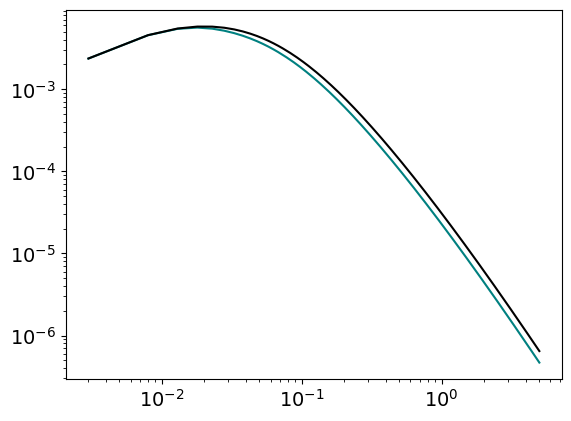

In [67]:
fig, ax = plt.subplots()


ax.plot(kh_arr/hlittle,sigma_k2(kh_arr,0, TFmdm), color='teal', alpha=1, label= 'cm21')
ax.plot(kh_arr/hlittle,sigma_k2(kh_arr,0, T_master_CDM), color='black', alpha=1, label= 'cm21')

plt.xscale('log')
plt.yscale('log')

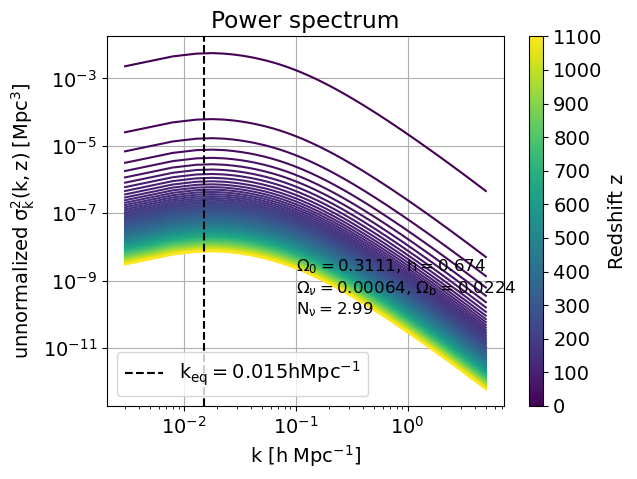

In [68]:
fig, ax = plt.subplots()

# plot sigma_k2 for as many redshifts indicated by n_plots
n_plots = 100  # Number of times I want to plot the function
colormap = plt.cm.viridis  
colorlist = [colormap(i) for i in np.linspace(0, 1, n_plots)]

redshifts= np.linspace(0,1100,n_plots)
color=0
for redshift in redshifts:
    ax.plot(kh_arr/hlittle,sigma_k2(kh_arr,redshift, USE_TRANSFER), color=colorlist[color], alpha=1)
    color+=1

# Plot the value of the scale of matter-radiation equality
plt.axvline(k_eq, color='black', linestyle='--', label=r'$\rm k_{eq}=$'+'{}'.format(round(k_eq,3)) + r'$\rm h Mpc^{-1}$')

# Make the plot pretty
plt.xlabel(r'k [$\rm h \; Mpc^{-1}$]')
plt.ylabel(r'$\rm unnormalized \; \sigma_k^2 (k,z) \; [Mpc^{3}]$')
plt.title(label='Power spectrum')
plt.xscale('log')
plt.yscale('log')

plt.text(10e-2, 1*10e-11,  
         f'$\\Omega_0={OMm}$, $\\rm h={hlittle}$ \n$\\Omega_\\nu={OMnu}$, $\\rm \\Omega_b={OMb}$ \n$\\rm N_\\nu={Nnu}$', 
         fontsize=12)
plt.legend()
plt.grid()

# Add a colorbar for the different redshift plots
norm = Normalize(vmin=redshifts[-1], vmax=redshifts[0])
sm = ScalarMappable(norm=norm, cmap=plt.cm.viridis)
plt.colorbar(sm, ax=ax, ticks=np.linspace(1100, 0, 12), label='Redshift z', aspect=25)

The above plot shows the (NOT normalized with $\sigma_8$) power spectrum for different redshifts. 

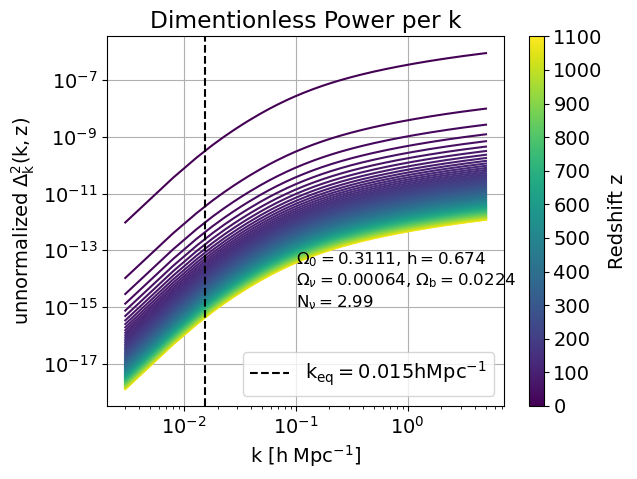

In [69]:
fig, ax = plt.subplots()

# plot power per k 
n_plots = 100  # Number of times you want to plot the function
colormap = plt.cm.viridis_r  # Choosing the 'viridis' colormap
colorlist = [colormap(i) for i in np.linspace(0, 1, n_plots)]


redshifts= np.linspace(1100,0,n_plots)
color=0
for redshift in redshifts:
    ax.plot(kh_arr/hlittle,power_per_k(kh_arr,redshift, USE_TRANSFER), color=colorlist[color], alpha=1)
    color+=1
    
    
# plt.plot(kh_arr/hlittle,power_per_k(kh_arr,0, USE_TRANSFER), color='teal')
plt.axvline(k_eq, color='black', linestyle='--', label=r'$\rm k_{eq}=$'+'{}'.format(round(k_eq,3)) + r'$\rm h Mpc^{-1}$')
plt.xlabel(r'k [$\rm h \; Mpc^{-1}$]')
plt.ylabel(r'$\rm unnormalized \;  \Delta_k^2 (k,z)$')
plt.title(label='Dimentionless Power per k')
plt.xscale('log')
plt.yscale('log')
plt.text(10e-2, 1*10e-16,  
         f'$\\Omega_0={OMm}$, $\\rm h={hlittle}$ \n$\\Omega_\\nu={OMnu}$, $\\rm \\Omega_b={OMb}$ \n$\\rm N_\\nu={Nnu}$', 
         fontsize=12)
plt.legend()
plt.grid()


# Now, correctly associate the ScalarMappable with the colormap and its normalization
norm = Normalize(vmin=redshifts[-1], vmax=redshifts[0])
sm = ScalarMappable(norm=norm, cmap=plt.cm.viridis)

# Correctly adding the colorbar by specifying the Axes to steal space from
# plt.colorbar(sm, ax=ax, label='Redshift z')
plt.colorbar(sm, ax=ax, ticks=np.linspace(1100, 0, 12), label='Redshift z', aspect=25)

The plot above shows the power per k (NOT normalised with $\sigma_8$ and volume) $\Delta_k^2$

The redshift dependence will be removed at the end 

## Step 2: Calculate the Mass Power Spectrum (i.e. variance in the mass field) using some window function

$$ \sigma^2_M(R) \equiv \left<\delta_M^2 \right> = \frac{1}{V_W^2} \int_0^\infty \Delta_k^2 W_k^2 \frac{dk}{k}$$


<br>

### 2.1 Window function

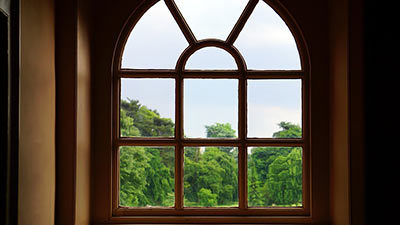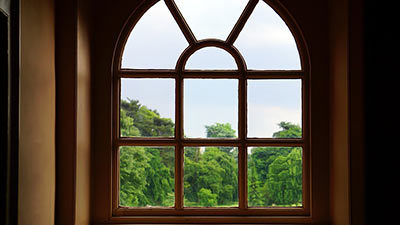

In [70]:
def window(space_variable,
           type_ = 'spherical_top_hat', # spherical_top_hat,  sharp_k_space   or   gaussian 
           R = 8/hlittle ,                       # Mpc
           space='k'):           # k or r
    
    # SPHERICAL TOP HAT--------------------------------------------------------
    if type_=='spherical_top_hat':
        Vw = 4*np.pi/3  * pow(R, 3)
        if space == 'r':
            if abs(space_variable)<=R : return 1
            else                      : return 0 
        if space == 'k': 
            return 4* np.pi * pow(R, 3) * (    np.sin(space_variable*R) / pow(space_variable* R , 3)  - np.cos(space_variable * R) / pow(space_variable* R , 2)          )  
        
    # SHARP k SPACE-------------------------------------------------------------
    if type_ == 'sharp_k_space':
        Vw = 6 * pow(np.pi, 2) * pow(R, 3)
        if space == 'r':
            return 3 * pow(space_variable / R , -3) * (  np.sin(space_variable / R) - space_variable/R * np.cos(space_variable/R)     ) 
        if space == 'k':
            if (abs(space_variable* R)<=1.0) : 
                return 1
            else: 
                return 0 
            
    # GAUSSIAN------------------------------------------------------------------
    
    if type_ == 'gaussian':
        Vw = pow(2*np.pi, 3/2.0) * pow(R, 3)
        if space == 'r':
            return np.exp(    -      pow(space_variable, 2) /  (2* pow(R, 2))               )
        if space == 'k':
            return Vw * np.exp( -   pow(space_variable * R, 2 )  / 2                      )
        
        
def volume_window(type_ = 'spherical_top_hat', # spherical_top_hat,  sharp_k_space   or   gaussian 
           R = 8/hlittle ):                       #  Mpc
                 

    # SPHERICAL TOP HAT--------------------------------------------------------
    if type_=='spherical_top_hat':
        Vw = 4*np.pi/3  * pow(R, 3)
        
    # SHARP k SPACE-------------------------------------------------------------
    if type_ == 'sharp_k_space':
        Vw = 6 * pow(np.pi, 2) * pow(R, 3)
            
    # GAUSSIAN------------------------------------------------------------------
    
    if type_ == 'gaussian':
        Vw = pow(2*np.pi, 3/2.0) * pow(R, 3)

    return Vw


# Radius to mass
def M_corresponding_to_R(R, type_of_window = 'spherical_top_hat'):
    return volume_window(type_ = type_of_window, R = R) * RHO_0 # M_sun


def R_corresponding_to_M(M, type_of_window = 'spherical_top_hat'):
    return pow(   M / ( volume_window(type_ = type_of_window, R = 1.0) * RHO_0 ) ,  1/3.0) # Mpc

<br>

### 2.2 Mass Variance

#### 2.2.1 Integrant: $\rm \frac{\Delta_k^2 W_k^2}{V_W^2k} $

In [71]:
# function to integrate:
def integrand(k, 
              R = 8/hlittle, # in Mpc
              Z = 0, 
              type_of_window = 'spherical_top_hat', 
              transfer = USE_TRANSFER):
    
    Vw = volume_window(type_ = type_of_window, R = R )
    return power_per_k(k, Z=Z , transfer = transfer)     *     pow(window(k, type_ = type_of_window, R = R , space='k'), 2)     *    1/k * pow(Vw, -2)

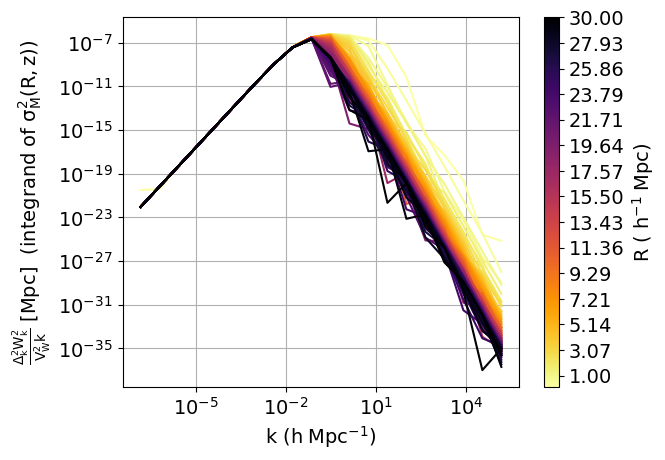

In [72]:
# kh_arr=np.linspace(1e-2,1e2,1000)
# kh_arr   = np.linspace(0.003*hlittle,5*hlittle,50)
kh_arr   = np.logspace(-7,5,20)
# how the integrand of the mass variance changes, with respect to R for redshift:
redshift = 0

# Start ploting----------------------------------------------------------
fig, ax = plt.subplots()

# plot power per k 
n_plots = 100  # Number of times you want to plot the function
colormap = plt.cm.inferno_r  # Choosing the 'viridis' colormap
colorlist = [colormap(i) for i in np.linspace(0, 1, n_plots)]


Rs = np.linspace(0.1,30,n_plots)
color=0
for R in Rs:
    ax.plot(kh_arr/hlittle,  
            integrand(kh_arr, R=R, Z=redshift,  type_of_window = 'spherical_top_hat', transfer = USE_TRANSFER),  
            color=colorlist[color], alpha=1)
    color+=1
    
    
# plt.plot(kh_arr/hlittle,integrand(kh_arr, R=0.1, Z=0,  type_of_window = 'spherical_top_hat', transfer = USE_TRANSFER), color='teal')
# plt.axvline(k_eq, color='black', linestyle='--', label=r'$\rm k_{eq}=$'+'{}'.format(round(k_eq,3)) + r'$\rm h Mpc^{-1}$')
plt.xlabel(r'k ($\rm h \; Mpc^{-1}$)')
plt.ylabel(r'$\rm \frac{\Delta_k^2 W_k^2}{V_W^2k} \; [Mpc] $  (integrand of $\rm \sigma^2_M(R, z)$)')
plt.xscale('log')
plt.yscale('log')
# plt.text(2.5*10e-4, 10e-7,
#          f'$\\Omega_0={OMm}$, $\\rm h={hlittle}$ \n$\\Omega_\\nu={OMnu}$, $\\rm \\Omega_b={OMb}$ \n$\\rm N_\\nu={Nnu}$, $\\rm z={redshift}$', 
#          fontsize=12)
# plt.legend()
plt.grid()
# plt.plot(kh_arr/hlittle,f(kh_arr, R=35))


# Add a colorbar for the different redshift plots
norm = Normalize(vmin=Rs[-1], vmax=Rs[0])
sm = ScalarMappable(norm=norm, cmap=plt.cm.inferno_r)
plt.colorbar(sm, ax=ax, ticks=np.linspace(1, 30, 15), label=r'R ( $\rm h^{-1} \; Mpc$)', aspect=25)

In the plot above we can see how the integrand of the mass variance changes with respect to R for a specific redshift indiceted by the text inside the plot. As we can see the integral in k should increase with R. Let's test it in the next plot.

#### 2.2.2 Integrate and get the mass variance as a function of R and z: 
$\rm \sigma^2_M(R,z)=\rm  \int_0^\infty\frac{\Delta_k^2 W_k^2}{V_W^2k} dk $: 

In [73]:
def sigma_m2(R, Z=0, norm8 = 1, type_of_window = USE_WINDOW, transfer = USE_TRANSFER):
#     xar = np.logspace(-3,1,100)
#     xar = np.logspace(-7,5,20)
#     yar=[]
#     for xar_i in xar:
#         yar.append(integrand(xar_i, R=R, Z=Z, type_of_window=type_of_window , transfer= transfer))
#     yar = integrand(xar, R=R, Z=Z, type_of_window=type_of_window , transfer= transfer)
#     return norm8 * simpson(y=yar,x=xar)

    return norm8 * quad(lambda k: integrand(k, R, Z, type_of_window, transfer), 0, np.inf)[0]  # or simpson(f,0.001, 1000, 100000)
# / volume_window(type_ = type_of_window, R = R)**2

#     return my_simpson(lambda k: integrand(k, R, Z, type_of_window, transfer),1e-7,1e5,100)


def sigma_m_m(M, Z=0, norm8=1, type_of_window =  USE_WINDOW, transfer = USE_TRANSFER):
    R = R_corresponding_to_M(M,type_of_window = type_of_window )
    return pow(sigma_m2(R, Z, norm8, type_of_window , transfer) , 1/2.0)

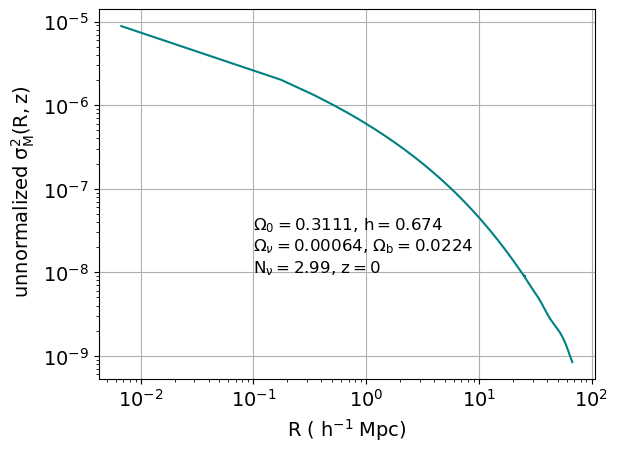

In [74]:
# how the mass variance changes, with respect to R for redshift:
redshift = 0

# Start ploting----------------------------------------------------------
R_arr = np.linspace(0.01,100,400)
result = []
for RR in R_arr:
    result.append(sigma_m2(RR))
# plt.plot(R_arr, result)
# plt.yscale('log')

plt.plot(R_arr*hlittle,result, color='teal')
# plt.axvline(k_eq, color='black', linestyle='--', label=r'$\rm k_{eq}=$'+'{}'.format(round(k_eq,3)) + r'$\rm h Mpc^{-1}$')
plt.xlabel(r'R ( $\rm h^{-1} \; Mpc$)')
plt.ylabel(r' $\rm unnormalized \; \sigma^2_M(R, z)$')
plt.xscale('log')
plt.yscale('log')
plt.text(10e-2, 1*10e-9,  
         f'$\\Omega_0={OMm}$, $\\rm h={hlittle}$ \n$\\Omega_\\nu={OMnu}$, $\\rm \\Omega_b={OMb}$ \n$\\rm N_\\nu={Nnu}$, $\\rm z={redshift}$', 
         fontsize=12)
# plt.legend()
plt.grid()

### 2.3 Normalized Mass Variance

In [75]:
norm8 = SIGMA8**2 / sigma_m2(R = 8/hlittle,type_of_window='spherical_top_hat' )

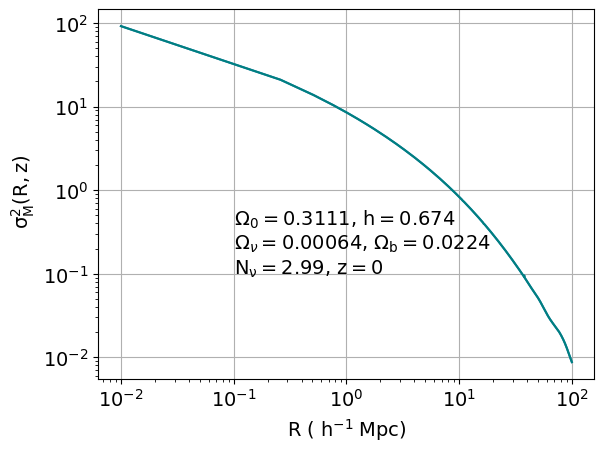

In [76]:
# how the mass variance changes, with respect to R for redshift:
redshift = 0

# Start ploting----------------------------------------------------------
R_arr = np.linspace(0.01,100,400)
result = []
for RR in R_arr:
    result.append(norm8* sigma_m2(RR))
plt.plot(R_arr, result)
# plt.yscale('log')

plt.plot(R_arr,result, color='teal')
# plt.axvline(k_eq, color='black', linestyle='--', label=r'$\rm k_{eq}=$'+'{}'.format(round(k_eq,3)) + r'$\rm h Mpc^{-1}$')
plt.xlabel(r'R ( $\rm h^{-1} \; Mpc$)')
plt.ylabel(r' $\rm \sigma^2_M(R, z) \;$')
plt.xscale('log')
plt.yscale('log')
plt.text(10e-2, 1*10e-2,  
         f'$\\Omega_0={OMm}$, $\\rm h={hlittle}$ \n$\\Omega_\\nu={OMnu}$, $\\rm \\Omega_b={OMb}$ \n$\\rm N_\\nu={Nnu}$, $\\rm z={redshift}$', 
         fontsize=14)
# plt.legend()
plt.grid()

Same but with respect to the mass:

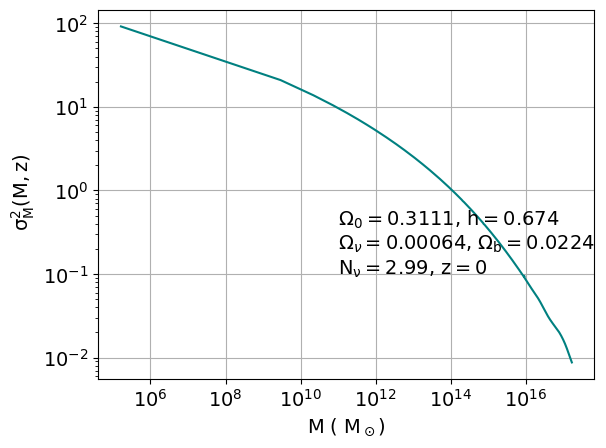

In [77]:
# how the mass variance changes, with respect to R for redshift:
redshift = 0

# Start ploting----------------------------------------------------------
R_arr = np.linspace(0.01,100,400)
result = []
for RR in R_arr:
    
    result.append(norm8* sigma_m2(RR))
    
plt.plot(M_corresponding_to_R(R_arr, type_of_window = 'spherical_top_hat'), result, color='teal')
# plt.yscale('log')

# plt.plot(R_arr,result, color='teal')
# plt.axvline(k_eq, color='black', linestyle='--', label=r'$\rm k_{eq}=$'+'{}'.format(round(k_eq,3)) + r'$\rm h Mpc^{-1}$')
plt.xlabel(r'M ( $\rm M_\odot$)')
plt.ylabel(r' $\rm \sigma^2_M(M, z)\;$')
plt.xscale('log')
plt.yscale('log')
plt.text(10e10, 1*10e-2,  
         f'$\\Omega_0={OMm}$, $\\rm h={hlittle}$ \n$\\Omega_\\nu={OMnu}$, $\\rm \\Omega_b={OMb}$ \n$\\rm N_\\nu={Nnu}$, $\\rm z={redshift}$', 
         fontsize=14)
# plt.legend()
plt.grid()

## Step 3: Calculate the Press Schechter HMF:

$$\frac{df_{coll}(>M,z)}{dM} = \sqrt{\frac{2}{\pi}}   \frac{\delta_c(z)}{\sigma_M^2(M)}  \left| \frac{d\sigma_M(M)}{dM}  \right|  exp \left[ - \frac{\delta_c^2(z)}{2\sigma_M^2(M)} \right]$$


$$\frac{dn(>M)}{dM} = \frac{\bar{\rho_0}}{M} \frac{df_{coll}(>M,z)}{dM} $$

In [78]:
def derivative(function, point, h):  
    return (function(point + h) - function(point - h)) / (2 * h)

def my_derivative(function, point, h = 'dummy'):
    xar =  np.linspace(1e10,1e15)
    yar = []
    for xar_i in xar:
        yar.append(function(xar_i))
    return derivative2(xar,yar,point,1)

In [79]:
def delta_c(Z, M='dummy'):
    return 1.686/growth_factor(Z)

def delta_c_e(Z, M, norm8, type_of_window,transfer, a=0.707, b= 0.34, c=0.81):
    sm2 = sigma_m2(R = R_corresponding_to_M(M, type_of_window=type_of_window), 
                                  Z = Z, 
                                  norm8 = norm8,
                                  type_of_window=type_of_window,
                                  transfer = transfer )
    return np.sqrt(a) * delta_c(Z) * (     1 + b*( sm2/(a*delta_c(Z)**2) )**c      )
    


def my_hmf(M,Z, norm8 = norm8, type_of_window = 'spherical_top_hat', transfer = USE_TRANSFER):
    sm2 = sigma_m2(R = R_corresponding_to_M(M, type_of_window=type_of_window), 
                                  Z = 0, # put dependence in delta_c
                                  norm8 = norm8,
                                  type_of_window=type_of_window,
                                  transfer = transfer )
    M_arr  = np.linspace(1e7,1e15,500)
    return ( 1.0
            * RHO_0/M 
            * pow(2/np.pi, 1/2.0) 
            * delta_c(Z) / sm2 
            * abs(derivative(lambda M: sigma_m_m(M, Z=0, norm8=norm8, type_of_window=type_of_window), M , 1000) )
            * np.exp(- pow(delta_c(Z), 2) / (2 * sm2 ) )
           )  
           
    
def my_hmf_ST(M,Z, norm8 = norm8, type_of_window = 'spherical_top_hat', transfer = USE_TRANSFER, 
              ellipsoidal = True,
              A = 0.353,
              p = 0.175,
              a = 0.707,
              b = 0.34,
              c = 0.81
             ):
    sm2 = sigma_m2(R = R_corresponding_to_M(M, type_of_window=type_of_window), 
                                  Z = 0, 
                                  norm8 = norm8,
                                  type_of_window=type_of_window,
                                  transfer = transfer )
    
    if ellipsoidal == True:
        dc= delta_c_e(Z=Z, M=M, norm8=norm8, type_of_window=type_of_window ,transfer = transfer, a=a, b= b, c=c)
    else: 
        dc= delta_c(Z)
    nu_hat = np.sqrt(a)* dc / sigma_m_m(M, Z=0, norm8=norm8,type_of_window=type_of_window)
#     np.sqrt(a) * delta_c(Z) * (     1 + b*( sm2/(a*delta_c(Z)**2) )**c          )
    
    return (-1.0
            * RHO_0/M
            * 1 / sigma_m_m(M, Z=0, norm8=norm8,type_of_window=type_of_window)
            * derivative(lambda M: sigma_m_m(M, Z=0, norm8=norm8,type_of_window=type_of_window), M , 10)
            * np.sqrt(2/np.pi) 
            * A
            * (1 + pow(nu_hat, -2*p))
            * nu_hat
            * np.exp(- nu_hat**2/2.0)
    )

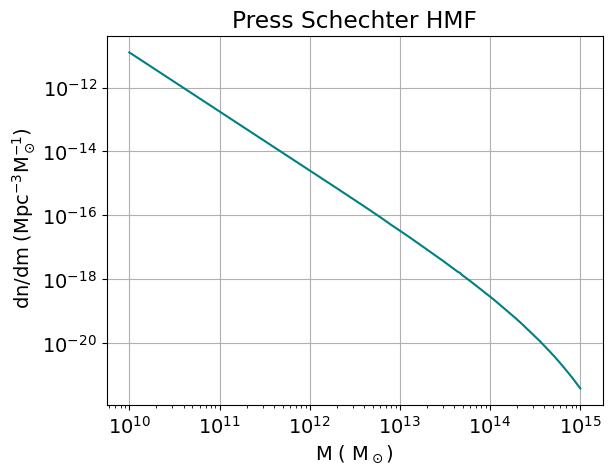

In [80]:
# how the mass variance changes, with respect to R for redshift:
redshift = 0

# Start ploting----------------------------------------------------------
R_arr  = np.linspace(0.01,100,400)
# M_arr  = M_corresponding_to_R(R_arr, type_of_window = 'spherical_top_hat')
M_arr  = np.linspace(1e10,1e15,500)
result = []
for ΜΜ in M_arr:
    
    result.append(my_hmf(ΜΜ, Z=0, norm8=norm8))
    
plt.plot(M_arr, result, color='teal')

# plt.yscale('log')

# plt.plot(R_arr,result, color='teal')
# plt.axvline(k_eq, color='black', linestyle='--', label=r'$\rm k_{eq}=$'+'{}'.format(round(k_eq,3)) + r'$\rm h Mpc^{-1}$')
plt.xlabel(r'M ( $\rm M_\odot$)')
plt.ylabel(r' $\rm dn/dm \; ({\rm Mpc}^{-3}M_\odot^{-1}) $')
plt.title(label='Press Schechter HMF')
plt.xscale('log')
plt.yscale('log')
# plt.text(10e8, 1*10e-8,  
#          f'$\\Omega_0={OMm}$, $\\rm h={hlittle}$ \n$\\Omega_\\nu={OMnu}$, $\\rm \\Omega_b={OMb}$ \n$\\rm N_\\nu={Nnu}$, $\\rm z={redshift}$', 
#          fontsize=12)
# plt.legend()
plt.grid()

## 0.0 Check with Steven

In [81]:
mf = hmf.MassFunction(z               = REDSHIFT,
                  transfer_model  = 'EH_NoBAO', 
                  lnk_min         = lnkmin, 
                  lnk_max         = lnkmax, 
                  dlnk            = dlnk, 
#                   transfer_params = {"use_sugiyama_baryons": True}, 
#                   cosmo_model     = cosmo_model,
                  cosmo_params    = {'Om0': OMm-OMnu, 
                                     'Ob0' : OMb, 
#                                      'Ol0' : 1. - OMm,
                                     'H0' : H_0,
#                                      'Ode0': OMl,
                                     'Tcmb0': THETA27*2.7,
                                     'Neff': Nnu,
                                     'm_nu': 91.5 * OMnu* pow(hlittle, 2)* pow(Nnu, -1) * pow(c2, -1)   , # eV
                                     'Ob0': OMb  
                                      },
                  n               = PS_index_n,
                  sigma_8         = SIGMA8,
                  takahashi       = False,
                  growth_model    = hmf.cosmology.growth_factor.Carroll1992,
                  growth_params   = {},
                  hmf_model       = hmf.mass_function.fitting_functions.PS,
                  hmf_params      = {},
                  filter_model    = hmf.density_field.filters.TopHat,
                  filter_params   = {},
                  disable_mass_conversion = False,
#                   mdef_model      = hmf.halos.mass_definitions.SOCritical,
                  mdef_params     = {},
                  Mmin            = 10,
                  Mmax            = 15,
                  dlog10m         = 0.01,
#                   delta_c         = delta_c(REDSHIFT)
                  
                
                  )

In [82]:
print('Steven\'s Normalization:', mf._normalisation**2,
      '\nMy Normalization:'     , norm8)
# Note that this could be different depending on the parameters, 
# Steven handles the redshift dependence and the normalization differently

Steven's Normalization: 2189165.5683939443 
My Normalization: 10393183.39508162


#### 0.1 Transfer function

In [83]:
# mf.parameter_info()
mf.quantities_available()
# mf.get_all_parameter_names()

['ERROR_ON_BAD_MDEF',
 '_dlnsdlnm',
 '_growth_factor_fn',
 '_gtm',
 '_normalisation',
 '_power0',
 '_sigma_0',
 '_unn_sig8',
 '_unn_sigma0',
 '_unnormalised_lnT',
 '_unnormalised_power',
 'cosmo',
 'delta_k',
 'dndlnm',
 'dndlog10m',
 'dndm',
 'filter',
 'fsigma',
 'growth',
 'growth_factor',
 'halo_overdensity_crit',
 'halo_overdensity_mean',
 'hmf',
 'how_big',
 'k',
 'lnsigma',
 'm',
 'mass_nonlinear',
 'mdef',
 'mean_density',
 'mean_density0',
 'n_eff',
 'ngtm',
 'nonlinear_delta_k',
 'nonlinear_power',
 'normalised_filter',
 'nu',
 'power',
 'radii',
 'rho_gtm',
 'rho_ltm',
 'sigma',
 'transfer',
 'transfer_function']

Text(0.1, 0.5, '$\\Omega_0=0.3111$, $\\rm h=0.674$ \n$\\Omega_\\nu=0.00064$, $\\rm \\Omega_b=0.0224$ \n$\\rm N_\\nu=2.99$, $\\rm z=0$')

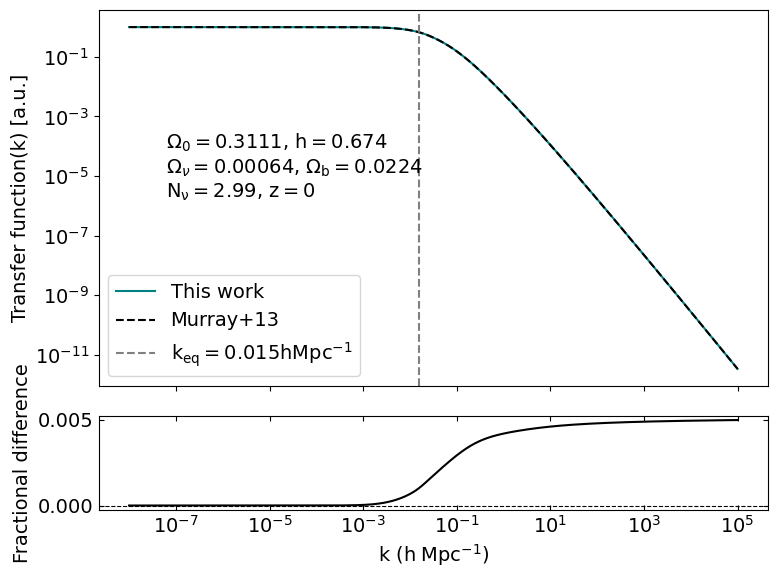

In [84]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

# mf.k is in h/Mpc
ax1.plot(mf.k, USE_TRANSFER(mf.k*hlittle, Z=REDSHIFT), color='teal', label= 'This work')
ax1.plot(mf.k, np.exp(mf._unnormalised_lnT), label = 'Murray+13', color='black', linestyle = '--')

# Plot the value of the scale of matter-radiation equality
ax1.axvline(k_eq, color='grey', linestyle='--', label=r'$\rm k_{eq}=$'+'{}'.format(round(k_eq,3)) + r'$\rm h Mpc^{-1}$')

# plt.plot(np.exp(tr_CDM._unnormalised_lnT), label='new', color='red')

ax1.set_ylabel('Transfer function(k) [a.u.]')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()

# Calculate the difference between the two functions
difference = abs(USE_TRANSFER(mf.k*hlittle, Z=REDSHIFT) -  (mf.transfer_function/mf._normalisation)) / (mf.transfer_function/mf._normalisation)

# Plot the difference on the second (bottom) subplot
ax2.plot(mf.k, difference, label='Difference', color='black')
ax2.set_xlabel(r'k ($\rm h \; Mpc^{-1}$)')
ax2.set_ylabel('Fractional difference')
ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal line at y=0
ax2.tick_params(which='both', direction='in', top=True, right=True)
ax2.set_xscale('log')
# Adjust layout
plt.tight_layout()

# Adding text to the first subplot for clarity
ax1.text(0.1, 0.5,  
         f'$\\Omega_0={OMm}$, $\\rm h={hlittle}$ \n$\\Omega_\\nu={OMnu}$, $\\rm \\Omega_b={OMb}$ \n$\\rm N_\\nu={Nnu}$, $\\rm z={redshift}$', 
         fontsize=14, transform=ax1.transAxes)



#### 0.2 $\sigma_k^2$

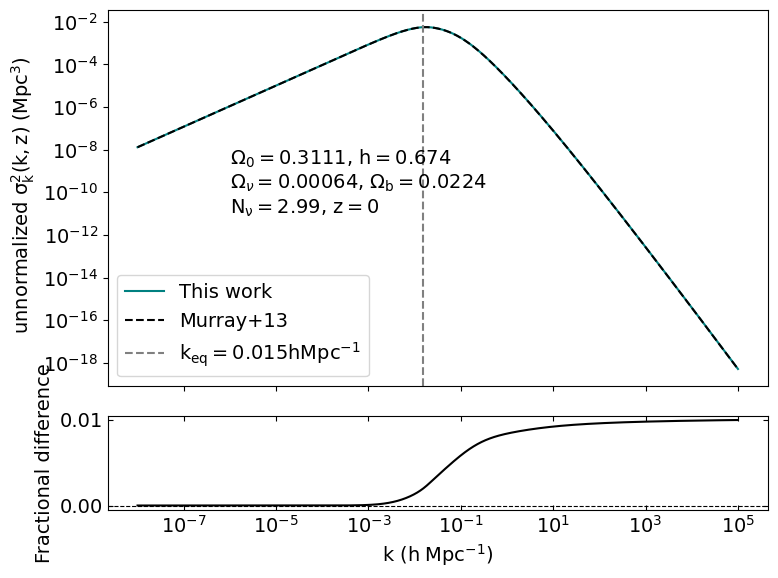

In [85]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

# tr.k is in h/Mpc

redshift = 0 # unnormalized_PS is extrapolated at z=0 in Steven

ax1.plot(mf.k,  sigma_k2(mf.k*hlittle, Z=redshift, transfer = USE_TRANSFER), color='teal', label= 'This work')
ax1.plot(mf.k, mf._unnormalised_power*hlittle**PS_index_n, label = 'Murray+13', color='black', linestyle = '--')
# Plot the value of the scale of matter-radiation equality
ax1.axvline(k_eq, color='grey', linestyle='--', label=r'$\rm k_{eq}=$'+'{}'.format(round(k_eq,3)) + r'$\rm h Mpc^{-1}$')


# ax1.set_xlabel(r'k ($\rm h \; Mpc^{-1}$)')
ax1.set_ylabel(r' unnormalized $\rm \sigma^2_k(k, z)\; (Mpc^3)$')
ax1.text(1e-6, 1e-11,  
         f'$\\Omega_0={OMm}$, $\\rm h={hlittle}$ \n$\\Omega_\\nu={OMnu}$, $\\rm \\Omega_b={OMb}$ \n$\\rm N_\\nu={Nnu}$, $\\rm z={redshift}$', 
         fontsize=14)


ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()


# ax1.text(0.1, 0.1,  
#          f'$\\Omega_0={OMm}$, $\\rm h={hlittle}$ \n$\\Omega_\\nu={OMnu}$, $\\rm \\Omega_b={OMb}$ \n$\\rm N_\\nu={Nnu}$, $\\rm z={redshift}$', 
#          fontsize=12, transform=ax1.transAxes)



# Calculate the difference between the two functions
difference = abs(sigma_k2(mf.k*hlittle, Z=redshift, transfer = USE_TRANSFER) - (mf._unnormalised_power*hlittle**PS_index_n)) / (mf._unnormalised_power*hlittle**PS_index_n)

# Plot the difference on the second (bottom) subplot
ax2.plot(mf.k, difference, label='Difference', color='black')
ax2.set_xlabel(r'k ($\rm h \; Mpc^{-1}$)')
ax2.set_ylabel('Fractional difference')
ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal line at y=0
ax2.tick_params(which='both', direction='in', top=True, right=True)
ax2.set_xscale('log')
# Adjust layout
plt.tight_layout()

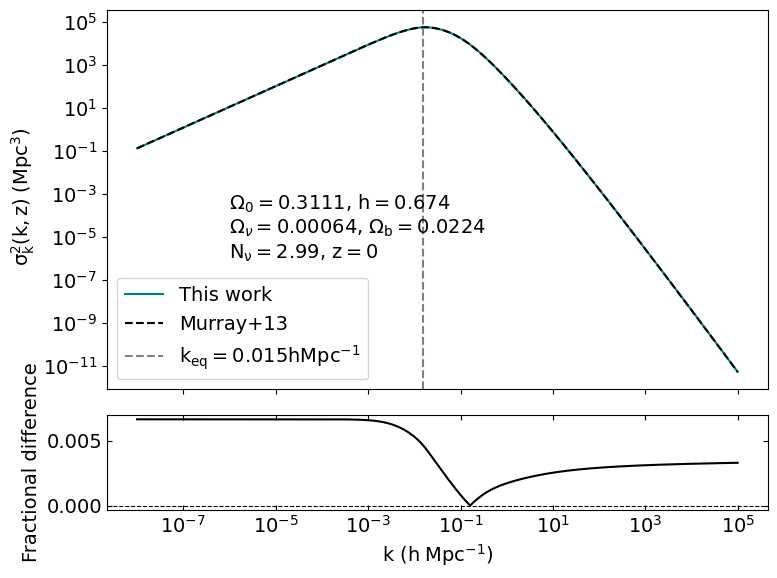

In [86]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

# tr.k is in h/Mpc

redshift = REDSHIFT

ax1.plot(mf.k, norm8* sigma_k2(mf.k*hlittle, Z=redshift, transfer = USE_TRANSFER), color='teal', label= 'This work')
ax1.plot(mf.k, mf.power/hlittle**3, label = 'Murray+13', color='black', linestyle = '--')
# Plot the value of the scale of matter-radiation equality
ax1.axvline(k_eq, color='grey', linestyle='--', label=r'$\rm k_{eq}=$'+'{}'.format(round(k_eq,3)) + r'$\rm h Mpc^{-1}$')


# ax1.set_xlabel(r'k ($\rm h \; Mpc^{-1}$)')
ax1.set_ylabel(r' $\rm \sigma^2_k(k, z)\; (Mpc^3)$')
ax1.text(1e-6, 1e-6,  
         f'$\\Omega_0={OMm}$, $\\rm h={hlittle}$ \n$\\Omega_\\nu={OMnu}$, $\\rm \\Omega_b={OMb}$ \n$\\rm N_\\nu={Nnu}$, $\\rm z={redshift}$', 
         fontsize=14)


ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()


# ax1.text(0.1, 0.1,  
#          f'$\\Omega_0={OMm}$, $\\rm h={hlittle}$ \n$\\Omega_\\nu={OMnu}$, $\\rm \\Omega_b={OMb}$ \n$\\rm N_\\nu={Nnu}$, $\\rm z={redshift}$', 
#          fontsize=12, transform=ax1.transAxes)



# Calculate the difference between the two functions
difference = abs(norm8 * sigma_k2(mf.k*hlittle, Z=redshift, transfer = USE_TRANSFER) - (mf.power/hlittle**3)) / (mf.power/hlittle**3)

# Plot the difference on the second (bottom) subplot
ax2.plot(mf.k, difference, label='Difference', color='black')
ax2.set_xlabel(r'k ($\rm h \; Mpc^{-1}$)')
ax2.set_ylabel('Fractional difference')
ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal line at y=0
ax2.tick_params(which='both', direction='in', top=True, right=True)
ax2.set_xscale('log')
# Adjust layout
plt.tight_layout()

#### 0.3 $\Delta_k^2$

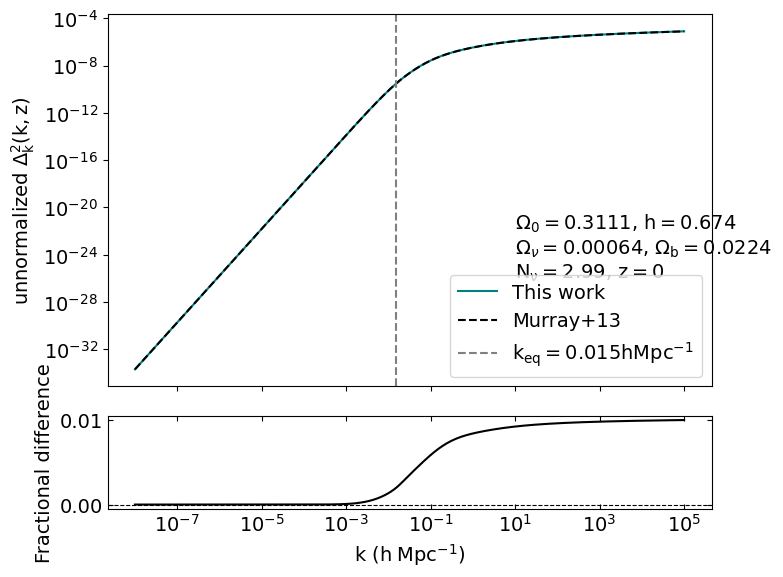

In [87]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

ax1.plot(mf.k, power_per_k(mf.k*hlittle ,Z=0, transfer = USE_TRANSFER), color='teal', label= 'This work')

unnormalized_delta_k = mf._unnormalised_power*hlittle**PS_index_n * (mf.k*hlittle)**3 /(2*np.pi**2)
ax1.plot(mf.k, unnormalized_delta_k, label = 'Murray+13', color='black', linestyle = '--')

ax1.axvline(k_eq, color='grey', linestyle='--', label=r'$\rm k_{eq}=$'+'{}'.format(round(k_eq,3)) + r'$\rm h Mpc^{-1}$')


# ax1.set_xlabel(r'k ($\rm h \; Mpc^{-1} $)')
ax1.set_ylabel(r'unnormalized $\rm \Delta^2_k(k, z)\;$')
ax1.text(1e1, 1e-26,  
         f'$\\Omega_0={OMm}$, $\\rm h={hlittle}$ \n$\\Omega_\\nu={OMnu}$, $\\rm \\Omega_b={OMb}$ \n$\\rm N_\\nu={Nnu}$, $\\rm z={redshift}$', 
         fontsize=14)


ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()



# Calculate the difference between the two functions
difference = abs(  power_per_k(mf.k*hlittle,Z=0, transfer = USE_TRANSFER) - (unnormalized_delta_k)) / ( unnormalized_delta_k)

# Plot the difference on the second (bottom) subplot
ax2.plot(mf.k, difference, label='Difference', color='black')
ax2.set_xlabel(r'k ($\rm h \; Mpc^{-1}$)')
ax2.set_ylabel('Fractional difference')
ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal line at y=0
ax2.tick_params(which='both', direction='in', top=True, right=True)
ax2.set_xscale('log')
# Adjust layout
plt.tight_layout()

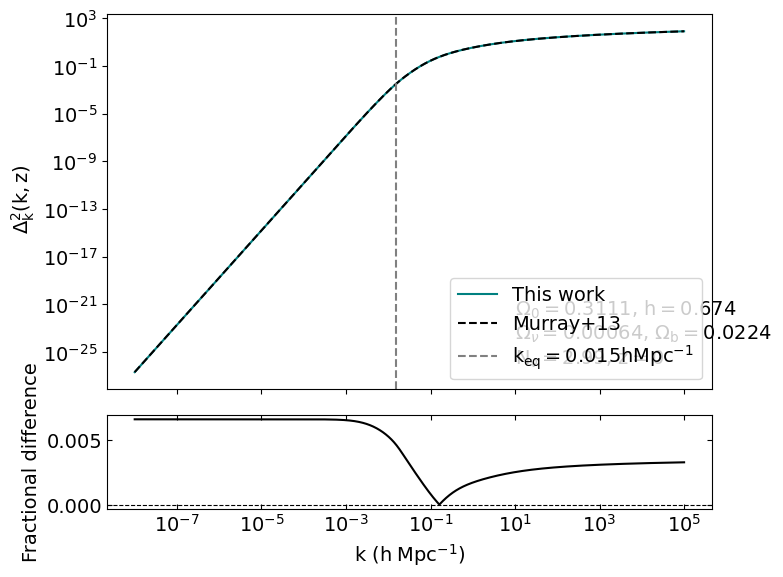

In [88]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [4, 1]})
redshift=REDSHIFT
ax1.plot(mf.k,  norm8*power_per_k(mf.k*hlittle ,Z=redshift, transfer = USE_TRANSFER), color='teal', label= 'This work')
ax1.plot(mf.k, mf.delta_k, label = 'Murray+13', color='black', linestyle = '--')

ax1.axvline(k_eq, color='grey', linestyle='--', label=r'$\rm k_{eq}=$'+'{}'.format(round(k_eq,3)) + r'$\rm h Mpc^{-1}$')


# ax1.set_xlabel(r'k ($\rm h \; Mpc^{-1} $)')
ax1.set_ylabel(r' $\rm \Delta^2_k(k, z)\;$')
ax1.text(1e1, 1e-26,  
         f'$\\Omega_0={OMm}$, $\\rm h={hlittle}$ \n$\\Omega_\\nu={OMnu}$, $\\rm \\Omega_b={OMb}$ \n$\\rm N_\\nu={Nnu}$, $\\rm z={redshift}$', 
         fontsize=14)


ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()



# Calculate the difference between the two functions
difference = abs( norm8 * power_per_k(mf.k*hlittle,Z=redshift, transfer = USE_TRANSFER) - ( mf.delta_k)) / ( mf.delta_k)

# Plot the difference on the second (bottom) subplot
ax2.plot(mf.k, difference, label='Difference', color='black')
ax2.set_xlabel(r'k ($\rm h \; Mpc^{-1}$)')
ax2.set_ylabel('Fractional difference')
ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal line at y=0
ax2.tick_params(which='both', direction='in', top=True, right=True)
ax2.set_xscale('log')
# Adjust layout
plt.tight_layout()

### 0.4 $\sigma_m^2$

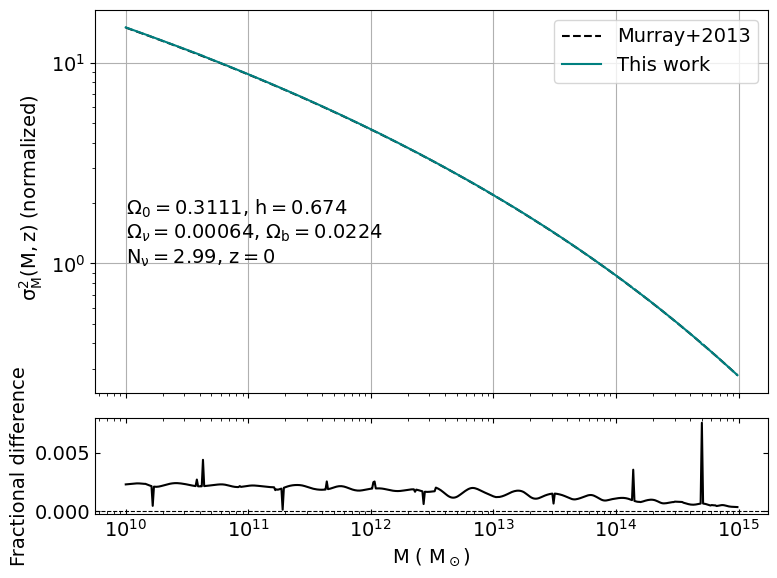

In [89]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

ax1.plot(mf.m, mf.sigma**2, label= 'Murray+2013', linestyle='--', color='black')


result=[]
for mff in mf.m:
    result.append(sigma_m2(R_corresponding_to_M(mff/hlittle), Z=redshift, norm8=norm8, transfer = USE_TRANSFER, type_of_window=USE_WINDOW ) )
ax1.plot(mf.m, result, color='teal', label='This work')
# ax1.set_xlabel(r'M ( $\rm M_\odot$)')
ax1.set_ylabel(r' $\rm \sigma^2_M(M, z)\; (normalized)$')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend()
ax1.grid()

ax1.text(1e10, 1e0,  
         f'$\\Omega_0={OMm}$, $\\rm h={hlittle}$ \n$\\Omega_\\nu={OMnu}$, $\\rm \\Omega_b={OMb}$ \n$\\rm N_\\nu={Nnu}$, $\\rm z={redshift}$', 
         fontsize=14)

# Calculate the difference between the two functions
difference = abs( result -  mf.sigma**2) /  mf.sigma**2

# Plot the difference on the second (bottom) subplot
ax2.plot(mf.m, difference, label='Difference', color='black')
ax2.set_xlabel(r'M ( $\rm M_\odot$)')
ax2.set_ylabel('Fractional difference')
ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal line at y=0
ax2.tick_params(which='both', direction='in', top=True, right=True)
ax2.set_xscale('log')
# Adjust layout
plt.tight_layout()

### 0.5 HMF

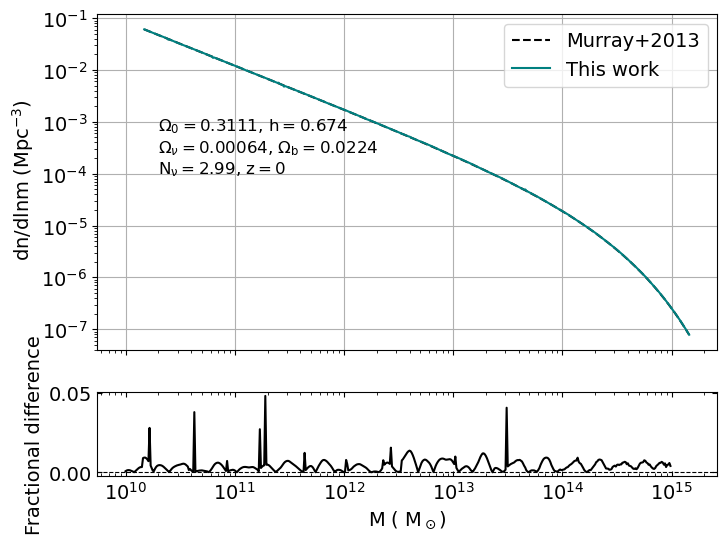

In [90]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

ax1.plot(mf.m/hlittle, mf.dndlnm*hlittle**4 , label= 'Murray+2013', linestyle='--', color='black')

result=[]
for mff in mf.m:
    result.append(mff* my_hmf(mff/hlittle, Z=REDSHIFT, norm8=norm8,  type_of_window = 'spherical_top_hat', transfer = USE_TRANSFER) )    
ax1.plot(mf.m/hlittle, result, color='teal', label='This work')
# ax1.set_xlabel(r'M ( $\rm M_\odot$)')
ax1.set_ylabel(r' $\rm dn/dlnm \; ({\rm Mpc}^{-3}) $')
ax1.text(2e10, 1e-4,  
         f'$\\Omega_0={OMm}$, $\\rm h={hlittle}$ \n$\\Omega_\\nu={OMnu}$, $\\rm \\Omega_b={OMb}$ \n$\\rm N_\\nu={Nnu}$, $\\rm z={redshift}$', 
         fontsize=12)

ax1.set_yscale('log')
ax1.set_xscale('log')




ax1.legend()
ax1.grid()


difference = abs( result -  mf.dndlnm*hlittle**4) / (mf.dndlnm*hlittle**4)



# Plot the difference on the second (bottom) subplot
ax2.plot(mf.m, difference, label='Difference', color='black')
ax2.set_xlabel(r'M ( $\rm M_\odot$)')
ax2.set_ylabel('Fractional difference')
ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal line at y=0
ax2.tick_params(which='both', direction='in', top=True, right=True)
ax2.set_xscale('log')
# Adjust layout
# plt.tight_layout()

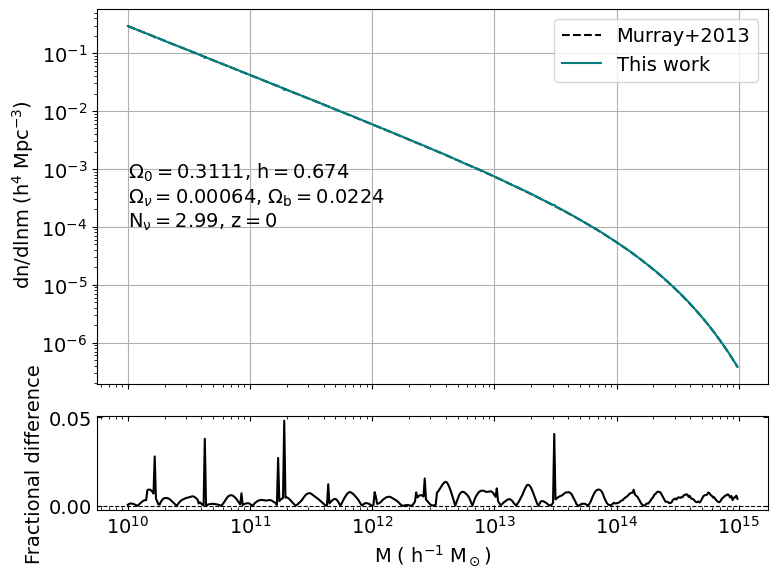

In [91]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

ax1.plot(mf.m, mf.dndlnm , label= 'Murray+2013', linestyle='--', color='black')

result=[]
for mff in mf.m:
    result.append( mff*hlittle**(-4)*my_hmf(mff/hlittle, Z=REDSHIFT, norm8=norm8, transfer= USE_TRANSFER) )    
ax1.plot(mf.m, result, color='teal', label='This work')
# ax1.xlabel(r'M ( $\rm h^{-1} \;M_\odot$)')
ax1.set_ylabel(r' $\rm dn/dlnm \; ({\rm h^4 \; Mpc}^{-3}) $')
ax1.text(1e10, 1e-4,  
         f'$\\Omega_0={OMm}$, $\\rm h={hlittle}$ \n$\\Omega_\\nu={OMnu}$, $\\rm \\Omega_b={OMb}$ \n$\\rm N_\\nu={Nnu}$, $\\rm z={REDSHIFT}$', 
         fontsize=14)

ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.legend()
ax1.grid()


# ax1.text(1e10, 1e-15,  
#          f'$\\Omega_0={OMm}$, $\\rm h={hlittle}$ \n$\\Omega_\\nu={OMnu}$, $\\rm \\Omega_b={OMb}$ \n$\\rm N_\\nu={Nnu}$, $\\rm z={redshift}$', 
#          fontsize=12)

# Calculate the difference between the two functions
difference = abs( result - mf.dndlnm) / mf.dndlnm 

# Plot the difference on the second (bottom) subplot
ax2.plot(mf.m, difference, label='Difference', color='black')
ax2.set_xlabel(r'M ( $\rm h^{-1} \;M_\odot$)')
ax2.set_ylabel('Fractional difference')
ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal line at y=0
ax2.tick_params(which='both', direction='in', top=True, right=True)
ax2.set_xscale('log')
# Adjust layout
plt.tight_layout()

In [1514]:
%%script echo skipping
# If you want comment out the previous line, but it takes a few seconds 

original_cmap = plt.cm.inferno
colors = original_cmap(np.linspace(0, 0.9, 256))  # Adjust 0.8 to control the cut-off
custom_cmap = LinearSegmentedColormap.from_list("cut_inferno", colors)

fig, ax = plt.subplots()

# plot sigma_k2 for as many redshifts indicated by n_plots

n_plots = 10  # Number of times I want to plot the function
colormap = plt.cm.viridis  # Choosing colormap
colorlist = [colormap(i) for i in np.linspace(0, 1, n_plots)]

redshifts= np.linspace(0,1,n_plots)
color=0
for zz in redshifts:
    
    result=[]
    for mff in mf.m:
        result.append( mff*hlittle**(-4)*my_hmf(mff/hlittle, Z=zz, norm8=norm8, transfer= USE_TRANSFER) )   
        
    ax.plot(mf.m, result, color=colorlist[color], alpha=1)
    color+=1

    
plt.xlabel(r'M ( $\rm h^{-1} \;M_\odot$)')
plt.ylabel(r' $\rm dn/dlnm \; ({\rm h^4 \; Mpc}^{-3}) $')
plt.text(1e10, 1e-6,  
         f'$\\Omega_0={OMm}$, $\\rm h={hlittle}$ \n$\\Omega_\\nu={OMnu}$, $\\rm \\Omega_b={OMb}$ \n$\\rm N_\\nu={Nnu}$', 
         fontsize=12)

plt.yscale('log')
plt.xscale('log')

# plt.legend()
plt.grid()


# Add a colorbar for the different redshift plots
norm = Normalize(vmin=0, vmax=1)
sm = ScalarMappable(norm=norm, cmap=colormap)
plt.colorbar(sm, ax=ax, ticks=np.linspace(1, 0, 11), label='Redshift z', aspect=25)

skipping


## Seth-Tormen HMF

In [1515]:
lnkmin, lnkmax, dlnk = np.log(1e-8), np.log(1e5), 0.01
c2 = 931.46 * 10e6 # eV


mf = hmf.MassFunction(z           = REDSHIFT,
                  transfer_model  = 'BBKS', 
                  lnk_min         = lnkmin, 
                  lnk_max         = lnkmax, 
                  dlnk            = dlnk, 
                  transfer_params = {"use_sugiyama_baryons": True}, 
#                   cosmo_model     = cosmo_model,
                  cosmo_params    = {'Om0': OMm-OMnu, 
                                     'Ob0' : OMb, 
#                                      'Ol0' : 1. - OMm,
                                     'H0' : H_0,
#                                      'Ode0': OMl,
                                     'Tcmb0': THETA27*2.7,
                                     'Neff': Nnu,
                                     'm_nu': 91.5 * OMnu* pow(hlittle, 2)* pow(Nnu, -1) * pow(c2, -1)   , # eV
                                     'Ob0': OMb  
                                      },
                  n               = PS_index_n,
                  sigma_8         = SIGMA8,
                  takahashi       = False,
                  growth_model    = hmf.cosmology.growth_factor.Carroll1992,
                  growth_params   = {},
                  hmf_model       = hmf.mass_function.fitting_functions.ST,
                  hmf_params      = {'A' : 0.353,
              'p' : 0.175,
              'a' : 0.707},
                  filter_model    = hmf.density_field.filters.TopHat,
                  filter_params   = {},
                  disable_mass_conversion = False,
#                   mdef_model      = hmf.halos.mass_definitions.SOCritical,
                  mdef_params     = {},
                  Mmin            = 10,
                  Mmax            = 15,
                  dlog10m         = 0.01,
#                   delta_c         = delta_c(1)
                  
                
                  )
print(mf.cosmo)

FlatLambdaCDM(name="Planck15 (modified)", H0=70.0 km / (Mpc s), Om0=1.0, Tcmb0=2.728 K, Neff=1.0, m_nu=[0.] eV, Ob0=0.05)


In [1516]:
def my_hmf_ST(M,Z, norm8 = norm8, type_of_window = 'spherical_top_hat', transfer = USE_TRANSFER, 
              ellipsoidal = False,
              A = 0.353,
              p = 0.175,
              a = 0.707,
              b = 0.34,
              c = 0.81
             ):
    sm2 = sigma_m2(R = R_corresponding_to_M(M, type_of_window=type_of_window), 
                                  Z = Z, 
                                  norm8 = norm8,
                                  type_of_window=type_of_window,
                                  transfer = transfer )
    
    if ellipsoidal == True:
        dc= delta_c_e(Z=Z, M=M, norm8=norm8, type_of_window=type_of_window ,transfer = transfer, a=a, b= b, c=c)
    else: 
        dc= delta_c(Z)
    nu_hat = np.sqrt(a)* dc / sigma_m_m(M, Z=0, norm8=norm8,type_of_window=type_of_window)
#     np.sqrt(a) * delta_c(Z) * (     1 + b*( sm2/(a*delta_c(Z)**2) )**c          )
    
    return (-1.0
            * RHO_0/M
            * 1 / sigma_m_m(M, Z=0, norm8=norm8,type_of_window=type_of_window)
            * derivative(lambda M: sigma_m_m(M, Z=0, norm8=norm8,type_of_window=type_of_window), M , 10)
            * np.sqrt(2/np.pi) 
            * A
            * (1 + pow(nu_hat, -2*p))
            * nu_hat
            * np.exp(- nu_hat**2/2.0)
    )

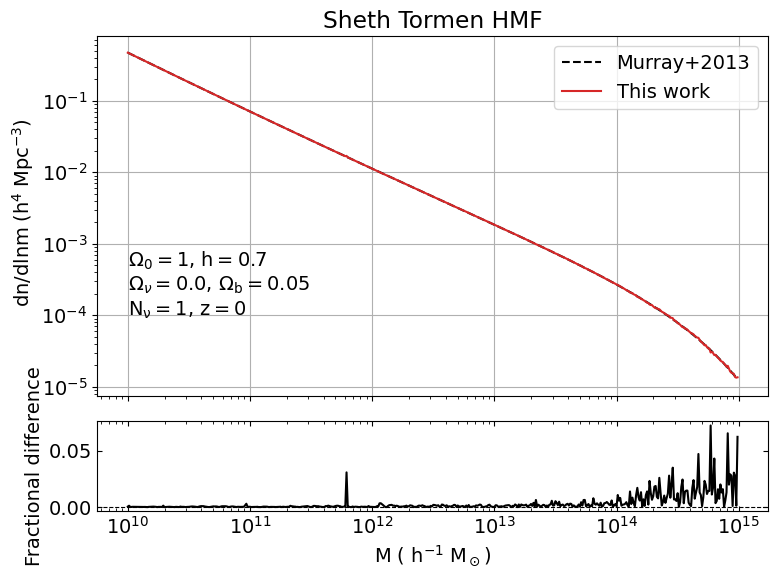

In [1517]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [4, 1]})
# plt.title(label='Seth Tormen HMF')
ax1.set_title('Sheth Tormen HMF')

ax1.plot(mf.m, mf.dndlnm , label= 'Murray+2013', linestyle='--', color='black')

result=[]
for mff in mf.m:
    result.append(mff* hlittle**(-4)*my_hmf_ST(mff/hlittle, Z=REDSHIFT, norm8=norm8, transfer= USE_TRANSFER, type_of_window='spherical_top_hat' ) )    
#     result.append(mff* hlittle**(-4)*my_hmf_ST(mff/hlittle, Z=redshift, norm8=norm8, transfer= USE_TRANSFER, type_of_window='gaussian') 
ax1.plot(mf.m, result , label= 'This work', linestyle='-', color='tab:red')

# result=[]
# for mff in mf.m:
#     result.append( hlittle**(-4)*my_hmf(mff/hlittle, Z=0, norm8=norm8, transfer= USE_TRANSFER) )    
# ax1.plot(mf.m, result, color='teal', label='This work')
# ax1.xlabel(r'M ( $\rm h^{-1} \;M_\odot$)')
ax1.set_ylabel(r' $\rm dn/dlnm \; ({\rm h^4 \; Mpc}^{-3}) $')
ax1.text(1e10, 1e-4,  
         f'$\\Omega_0={OMm}$, $\\rm h={hlittle}$ \n$\\Omega_\\nu={OMnu}$, $\\rm \\Omega_b={OMb}$ \n$\\rm N_\\nu={Nnu}$, $\\rm z={redshift}$', 
         fontsize=14)

ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.legend()
ax1.grid()


# ax1.text(1e10, 1e-15,  
#          f'$\\Omega_0={OMm}$, $\\rm h={hlittle}$ \n$\\Omega_\\nu={OMnu}$, $\\rm \\Omega_b={OMb}$ \n$\\rm N_\\nu={Nnu}$, $\\rm z={redshift}$', 
#          fontsize=12)

# Calculate the difference between the two functions
difference = abs( result - mf.dndlnm) / mf.dndlnm 

# Plot the difference on the second (bottom) subplot
ax2.plot(mf.m, difference, label='Difference', color='black')
ax2.set_xlabel(r'M ( $\rm h^{-1} \;M_\odot$)')
ax2.set_ylabel('Fractional difference')
ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal line at y=0
ax2.tick_params(which='both', direction='in', top=True, right=True)
ax2.set_xscale('log')
# Adjust layout
plt.tight_layout()

## Try a gaussian window function

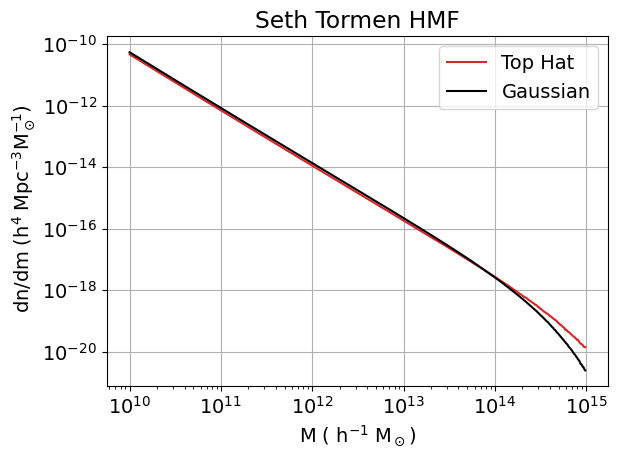

In [1518]:
redshift = 0
MF=mf.m

# Spherical top hat window function
result=[]
for mff in MF:
    result.append( hlittle**(-4)*my_hmf_ST(mff/hlittle, Z=redshift, norm8=norm8, transfer= USE_TRANSFER, type_of_window='spherical_top_hat') )    
plt.plot(MF, result , label= 'Top Hat', linestyle='-', color='tab:red')

# Gaussian window function
result=[]
for mff in MF:
    result.append( hlittle**(-4)*my_hmf_ST(mff/hlittle, Z=redshift, norm8=norm8, transfer= USE_TRANSFER, type_of_window='gaussian') )  
plt.plot(MF, result , label= 'Gaussian', linestyle='-', color='black')

# Make the plot pretty
plt.xlabel(r'M ( $\rm h^{-1} \;M_\odot$)')
plt.ylabel(r' $\rm dn/dm \; ({\rm h^4 \; Mpc}^{-3}M_\odot^{-1}) $')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.grid()
plt.title(label='Seth Tormen HMF')
plt.tight_layout()